In [1]:
!rm -rf /kaggle/working/*

In [2]:
import os
import numpy as np
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
clean_audio_dir = "/kaggle/input/steganaudio-data/data4ML/LSB_data/original"

lsb_audio_dir = "/kaggle/input/steganaudio-data/data4ML/LSB_data/hidden"

phase_audio_dir = "/kaggle/input/steganaudio-data/data4ML/PhaseCoding_data/hidden"

spread_audio_dir = "/kaggle/input/steganaudio-data/data4ML/SpreadSpectrum_data/hidden"

clean_image_dir = "/kaggle/working/clean"

lsb_image_dir = "/kaggle/working/lsb"

phase_image_dir = "/kaggle/working/phase"

spread_image_dir = "/kaggle/working/spread"

In [4]:
def create_and_save_spectrogram(audio_path, save_path):
    try:
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=None, mono=True)
        
        # Ensure the loaded audio is not empty
        if y.size == 0:
            raise ValueError(f"Audio file {audio_path} is empty or corrupted.")
            
        # Compute the mel spectrogram
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
        # # Expand dimensions to include the channel axis
        # spectrogram_db = np.expand_dims(spectrogram_db, axis=-1)
        
        # # Resize to the desired output size
        # spectrogram_resized = tf.image.resize(spectrogram_db, output_size).numpy()
        # return spectrogram_resized[..., 0]  # Remove the channel dimension for consistent input
        
        spectrogram_db -= spectrogram_db.min()
        spectrogram_db /= spectrogram_db.max()

        # Convert grayscale spectrogram to RGB using a colormap
        cmap = plt.get_cmap('jet')
        mel_rgb = cmap(spectrogram_db)[:, :, :3]  # Remove alpha channel

        # Resize to ensure consistent size
        mel_rgb = cv2.resize(mel_rgb, (128, 128))

        # Save as RGB image
        plt.imsave(save_path, mel_rgb)

    except Exception as e:
        print(f"Error creating spectrogram for {audio_path}: {e}")
        return None  # Return None for problematic files

In [5]:
def process_audio(audio_dir, output_dir):
    if audio_dir != "/kaggle/input/steganaudio-data/data4ML/LSB_data/original":
        limit = 100
    else:
        limit = 305
        
    os.makedirs(output_dir, exist_ok=True)   
    
    for file_name in os.listdir(audio_dir):
        if limit == 0:
            break
        if file_name.endswith('.wav'):  # Process only WAV files
            file_path = os.path.join(audio_dir, file_name)
            img_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}.png")
            create_and_save_spectrogram(file_path, img_path)
            

In [6]:
process_audio(clean_audio_dir, clean_image_dir )
process_audio(lsb_audio_dir, lsb_image_dir)
process_audio(phase_audio_dir, phase_image_dir)
process_audio(spread_audio_dir, spread_image_dir)

/tmp/ipykernel_30/3567056489.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None, mono=True)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error creating spectrogram for /kaggle/input/steganaudio-data/data4ML/LSB_data/original/audio_512.wav: 


In [7]:
def load_spectrograms(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(64, 64))  # Resize to 128x128
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [8]:
clean_data, clean_label = load_spectrograms(clean_image_dir, label=0)
lsb_data, lsb_label = load_spectrograms(lsb_image_dir, label=1)
phase_data, phase_label = load_spectrograms(phase_image_dir, label=2)
spread_data, spread_label = load_spectrograms(spread_image_dir, label=3)

In [9]:
X = np.concatenate([clean_data, lsb_data, phase_data, spread_data], axis=0)
y = np.concatenate([clean_label, lsb_label, phase_label, spread_label], axis=0)

In [10]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
print(X_train.shape)
print(X_test.shape)

(842, 64, 64, 3)
(362, 64, 64, 3)


In [13]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  
])
# model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(256, activation='relu'),
#         Dropout(0.5),
#         Dense(4, activation='softmax')
#     ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the CNN
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,612 (2.61 MB)

 Trainable params: 684,164 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50


I0000 00:00:1738685443.666667     116 service.cc:145] XLA service 0x7eecc8001c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738685443.666717     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3948 - loss: 3.9452 

I0000 00:00:1738685449.880845     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.4397 - loss: 3.2196 - val_accuracy: 0.4793 - val_loss: 1.5327
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5843 - loss: 0.9440 - val_accuracy: 0.2544 - val_loss: 4.7928
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5440 - loss: 0.8610 - val_accuracy: 0.2544 - val_loss: 10.0884
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6087 - loss: 0.7774 - val_accuracy: 0.2544 - val_loss: 17.4167
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5860 - loss: 0.7966 - val_accuracy: 0.2544 - val_loss: 26.3977
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5709 - loss: 0.8138 - val_accuracy: 0.2544 - val_loss: 30.1035
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5595 - loss: 0.8036 - val_accuracy: 0.2544 - val_loss: 32.1434
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5693 - loss: 0.7925 - val_accuracy: 0.2544 - val_loss: 36

Test Accuracy: 61.60%


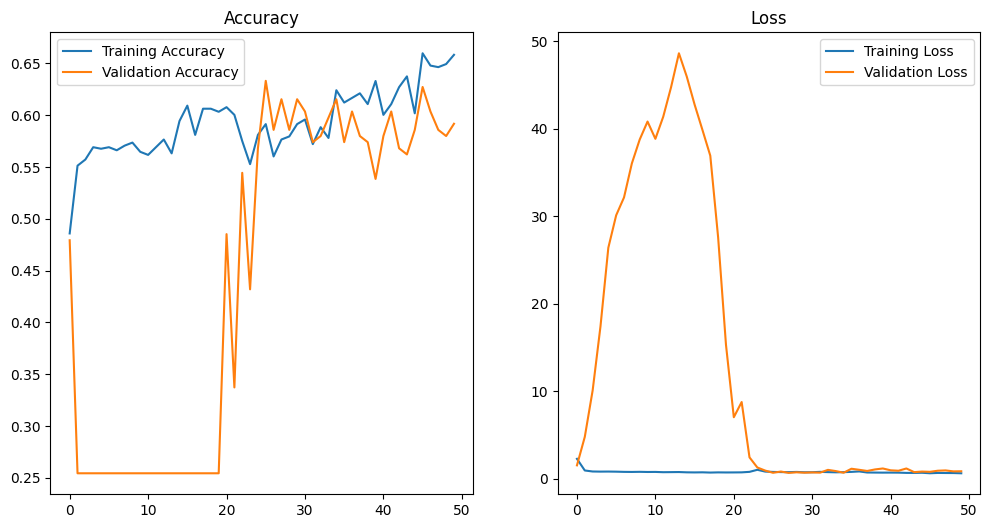

In [15]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot Training History
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [16]:
# def classify_audio(file_path):
#     spectrogram = create_spectrogram(file_path).reshape(1, 128, 128, 1) / 255.0
#     spectrogram = np.repeat(spectrogram, 3, axis=-1)
#     prediction = model.predict(spectrogram)
#     class_idx = np.argmax(prediction)
#     methods = ["Clean", "LSB", "Phase Coding", "Spread Spectrum"]
#     return methods[class_idx]

In [17]:
# test_audio_path = "/kaggle/input/file-test/testing-file.wav"
# result = classify_audio(test_audio_path)
# print(f"The audio file is classified as: {result}")